In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from glob import glob
import pickle

from PIL import ImageColor
import matplotlib.colors

from utils import NN_FEATURES_DIR, RESULTS_DIR, SUBJECTS, NUM_TEST_STIMULI
from analyses.ridge_regression_decoding import NUM_CV_SPLITS, DECODER_OUT_DIR, calc_rsa, calc_rsa_images, calc_rsa_captions, get_fmri_data, pairwise_accuracy, ACC_MODALITY_AGNOSTIC, ACC_CAPTIONS, ACC_IMAGES, get_default_features, get_default_vision_features, get_default_lang_features, MOD_SPECIFIC_IMAGES, MOD_SPECIFIC_CAPTIONS
from notebook_utils import add_avg_subject, create_result_graph, plot_metric_catplot, plot_metric, load_results_data, ACC_MEAN

# Zero-shot cross-modal decoding

In [2]:

models = ["clip", "flava", "imagebind", "blip2"]
all_data = load_results_data(models)

data_models = all_data.copy()

data_models = data_models[pd.isna(data_models["mask"])]
data_models = data_models[data_models.surface == False]

data_models

100%|██████████| 1196/1196 [00:11<00:00, 104.72it/s]


,alpha,model,subject,features,vision_features,lang_features,training_mode,mask,num_voxels,metric,value,surface,resolution,model_feat
0,100000.0,blip2,sub-01,avg,vision_features_cls,lang_features_cls,modality-agnostic,None,162649,pairwise_acc_modality_agnostic,0.868323,False,NaN,blip2_avg
1,100000.0,blip2,sub-01,avg,vision_features_cls,lang_features_cls,modality-agnostic,None,162649,pairwise_acc_captions,0.836853,False,NaN,blip2_avg
2,100000.0,blip2,sub-01,avg,vision_features_cls,lang_features_cls,modality-agnostic,None,162649,pairwise_acc_images,0.942029,False,NaN,blip2_avg
3,100000.0,blip2,sub-01,avg,vision_features_cls,lang_features_cls,modality-agnostic,None,162649,pairwise_acc_mean,0.889441,False,NaN,blip2_avg
4,100000.0,blip2,sub-01,avg,vision_features_cls,lang_features_mean,modality-agnostic,None,162649,pairwise_acc_modality_agnostic,0.866356,False,NaN,blip2_avg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1851,100000.0,imagebind,sub-07,concat,vision_features_cls,lang_features_cls,images,None,214739,pairwise_acc_mean,0.875880,False,NaN,imagebind_concat
1852,100000.0,imagebind,sub-07,matched,vision_features_cls,lang_features_cls,images,None,214739,pairwise_acc_modality_agnostic,0.829503,False,NaN,imagebind_matched
1853,100000.0,imagebind,sub-07,matched,vision_features_cls,lang_features_cls,images,None,214739,pairwise_acc_captions,0.748033,False,NaN,imagebind_matched
1854,100000.0,imagebind,sub-07,matched,vision_features_cls,lang_features_cls,images,None,214739,pairwise_acc_images,0.953002,False,NaN,imagebind_matched


In [3]:
data_cls_feats = data_models.copy()
for model in all_data.model.unique():
    data_cls_feats = data_cls_feats[((data_cls_feats.model == model) & (data_cls_feats.vision_features == "vision_features_cls") & (data_cls_feats.lang_features == "lang_features_cls")) | (data_cls_feats.model != model)]
    
data_matched_feats = data_cls_feats[data_cls_feats.features == "matched"]
data_matched_feats

,alpha,model,subject,features,vision_features,lang_features,training_mode,mask,num_voxels,metric,value,surface,resolution,model_feat
48,100000.0,blip2,sub-01,matched,vision_features_cls,lang_features_cls,modality-agnostic,None,162649,pairwise_acc_modality_agnostic,0.862836,False,NaN,blip2_matched
49,100000.0,blip2,sub-01,matched,vision_features_cls,lang_features_cls,modality-agnostic,None,162649,pairwise_acc_captions,0.805590,False,NaN,blip2_matched
50,100000.0,blip2,sub-01,matched,vision_features_cls,lang_features_cls,modality-agnostic,None,162649,pairwise_acc_images,0.931470,False,NaN,blip2_matched
51,100000.0,blip2,sub-01,matched,vision_features_cls,lang_features_cls,modality-agnostic,None,162649,pairwise_acc_mean,0.868530,False,NaN,blip2_matched
72,100000.0,clip,sub-01,matched,vision_features_cls,lang_features_cls,modality-agnostic,None,162649,pairwise_acc_modality_agnostic,0.872981,False,NaN,clip_matched
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1839,100000.0,flava,sub-07,matched,vision_features_cls,lang_features_cls,images,None,214739,pairwise_acc_mean,0.845031,False,NaN,flava_matched
1852,100000.0,imagebind,sub-07,matched,vision_features_cls,lang_features_cls,images,None,214739,pairwise_acc_modality_agnostic,0.829503,False,NaN,imagebind_matched
1853,100000.0,imagebind,sub-07,matched,vision_features_cls,lang_features_cls,images,None,214739,pairwise_acc_captions,0.748033,False,NaN,imagebind_matched
1854,100000.0,imagebind,sub-07,matched,vision_features_cls,lang_features_cls,images,None,214739,pairwise_acc_images,0.953002,False,NaN,imagebind_matched


In [4]:
def add_mean_cross_modal_and_within_modal_rows(data):
    extra_rows = []
    for model in data.model.unique():
        for subject in SUBJECTS:
            data_model_subj = data[(data.model == model) & (data.subject == subject)]
            # cross-modal
            cross_modal_train_images_eval_captions = data_model_subj[(data_model_subj.training_mode == "images") & (data_model_subj.metric == ACC_CAPTIONS)]
            cross_modal_train_captions_eval_images = data_model_subj[(data_model_subj.training_mode == "captions") & (data_model_subj.metric == ACC_IMAGES)]
    
            if len(cross_modal_train_captions_eval_images) > 0:
                assert len(cross_modal_train_images_eval_captions) == len(cross_modal_train_captions_eval_images) == 1
                mean_acc = (cross_modal_train_images_eval_captions.value.item() + cross_modal_train_captions_eval_images.value.item()) / 2
        
                mean_row = cross_modal_train_images_eval_captions.copy()
                mean_row["training_mode"] = "cross-modal"
                mean_row["metric"] = "mean"
                mean_row["value"] = mean_acc
                mean_row["condition"] = "cross-modal"
    
                extra_rows.append(mean_row)
    
            # within-modal
            within_modal_captions = data_model_subj[(data_model_subj.training_mode == "captions") & (data_model_subj.metric == ACC_CAPTIONS)]
            within_modal_images = data_model_subj[(data_model_subj.training_mode == "images") & (data_model_subj.metric == ACC_IMAGES)]
    
            if len(within_modal_captions) > 0:
                assert len(within_modal_captions) == len(within_modal_images) == 1
                mean_acc = (within_modal_captions.value.item() + within_modal_images.value.item()) / 2
        
                mean_row = within_modal_captions.copy()
                mean_row["training_mode"] = "within-modal"
                mean_row["metric"] = "mean"
                mean_row["value"] = mean_acc
                mean_row["condition"] = "within-modal"
    
                extra_rows.append(mean_row)
    
    extra_rows = pd.concat(extra_rows)
    data = pd.concat((data, extra_rows), ignore_index=True)
    return data
    # data_matched_with_mean[data_matched_with_mean.metric == "mean"]

In [5]:
data_matched_feats = add_mean_cross_modal_and_within_modal_rows(data_matched_feats)

In [6]:
DEFAULT_FEAT_OPTIONS = ["vision", "lang", "matched"]

def calc_model_feat_order(data, model_order, feat_options=DEFAULT_FEAT_OPTIONS):
    all_model_feats = data.model_feat.unique()
    all_models = data.model.unique()
    for model in all_models:
        if model not in model_order:
            raise RuntimeError(f"Model missing in order: {model}")
    model_feat_order = []
    for model in model_order:
        for feats in feat_options:
            model_feat = f"{model}_{feats}"
            if model_feat in all_model_feats:
                model_feat_order.append(model_feat)

    return model_feat_order

model      condition   
blip2      cross-modal     0.716580
           within-modal    0.867633
clip       cross-modal     0.664924
           within-modal    0.872429
flava      cross-modal     0.722032
           within-modal    0.870031
imagebind  cross-modal     0.730728
           within-modal    0.885559
Name: value, dtype: float64
model      condition   
blip2      cross-modal     6
           within-modal    6
clip       cross-modal     6
           within-modal    6
flava      cross-modal     6
           within-modal    6
imagebind  cross-modal     6
           within-modal    6
Name: value, dtype: int64


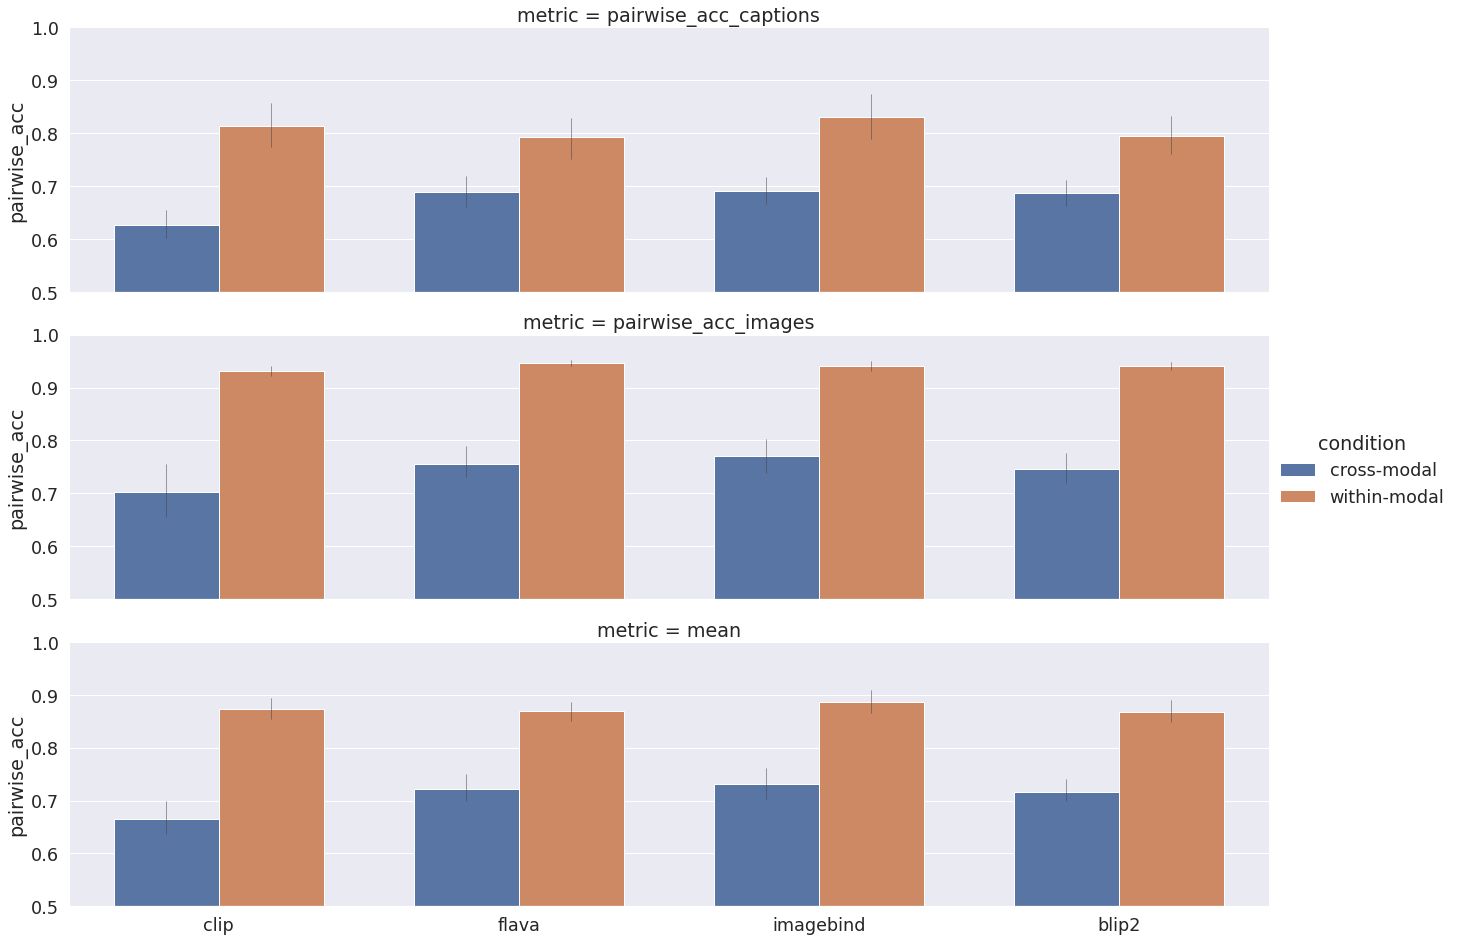

In [8]:
def create_zero_shot_cross_modal_plot(data, model_order):
    sns.set(font_scale=1.6)
    TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
    FEAT_ORDER = ["vision models", "language models", "multimodal models"]
    
    data_to_plot = data.copy()
    
    data_to_plot = data_to_plot[data_to_plot.training_mode != "modality-agnostic"]
    
    data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models", "matched": "multimodal models"})
    
    data_to_plot.loc[((data_to_plot.training_mode == "images") & (data_to_plot.metric == ACC_CAPTIONS)) | ((data_to_plot.training_mode == "captions") & (data_to_plot.metric == ACC_IMAGES)), "condition"] = "cross-modal"
    data_to_plot.loc[((data_to_plot.training_mode == "captions") & (data_to_plot.metric == ACC_CAPTIONS)) | ((data_to_plot.training_mode == "images") & (data_to_plot.metric == ACC_IMAGES)), "condition"] = "within-modal"
    
    model_feat_order = calc_model_feat_order(data_to_plot, model_order)
    
    
    metrics_order = [ACC_CAPTIONS, ACC_IMAGES, "mean"]
    
    height = 4.5
    aspect = 4
    
    condition_order = ["cross-modal", "within-modal"]
    
    for mode in ["captions", "images", "cross-modal", "within-modal"]:
        data_mode = data_to_plot[data_to_plot.training_mode == mode]
        for model in model_order:
            for condition in condition_order:
                length = len(data_mode[(data_mode.model == model) & (data_mode.condition == condition)])
                expected_num_datapoints = len(SUBJECTS)
                if (length > 0) and (length != expected_num_datapoints):
                    message = f"unexpected number of datapoints: {length} (expected: {expected_num_datapoints}) (model_feat: {model} {mode})"
                    print(f"Warning: {message}")
    
    g = sns.catplot(data_to_plot, kind="bar", x="model", order=model_order, y="value", row="metric", row_order=metrics_order, col=None, height=height, aspect=aspect, hue="condition", hue_order=condition_order,
                    palette=None, err_kws={'linewidth': 0.5, 'alpha': 0.99}, width=0.7)
       
    g.set(ylim=(0.5, 1), ylabel="pairwise_acc", xlabel='')
    return data_to_plot
    

data_plotted = create_zero_shot_cross_modal_plot(data_matched_feats, models)
plt.savefig(os.path.join(RESULTS_DIR, f"zero_shot_cross_modal.png"), bbox_inches='tight', pad_inches=0, dpi=300)

print(data_plotted[(data_plotted.metric == "mean")].groupby(["model", "condition"])['value'].mean())
print(data_plotted[(data_plotted.metric == "mean")].groupby(["model", "condition"])['value'].count())


# Zero-shot cross-modal decoding with Mask

In [9]:
model_order = ["blip2"]
# model_order = ["clip", "flava", "imagebind", "blip2"]

data_models = all_data[all_data.model.isin(model_order)].copy()

print(data_models["mask"].unique())
# mask_name = '/home/mitja/data/multimodal_decoding/searchlight/train/blip2/avg/fsaverage7/n_neighbors_200/masks/p_values_thresh_0.01.p'
mask_name = '/home/mitja/data/multimodal_decoding/searchlight/train/blip2/avg/fsaverage5/n_neighbors_200/masks/p_values_thresh_0.01.p'
# mask_name = '/home/mitja/data/multimodal_decoding/searchlight/train/blip2/avg/fsaverage5/n_neighbors_200/masks/p_values_thresh_0.01_left_cluster_0.p'

data_models = data_models[data_models["mask"] ==  mask_name]
data_models = data_models[data_models.surface == True]
print(data_models.resolution.unique())

data_cls_feats = data_models.copy()
for model in all_data.model.unique():
    data_cls_feats = data_cls_feats[((data_cls_feats.model == model) & (data_cls_feats.vision_features == "vision_features_cls") & (data_cls_feats.lang_features == "lang_features_cls")) | (data_cls_feats.model != model)]
    # data_cls_feats = data_cls_feats[((data_cls_feats.model == model) & (data_cls_feats.vision_features == "vision_features_mean") & (data_cls_feats.lang_features == "lang_features_mean")) | (data_cls_feats.model != model)]


data_matched_feats = data_cls_feats[data_cls_feats.features == "matched"]

data_matched_feats = add_mean_cross_modal_and_within_modal_rows(data_matched_feats)

# data_matched_feats

[None
 '/home/mitja/data/multimodal_decoding/searchlight/train/blip2/avg/fsaverage5/n_neighbors_200/p_values_metric_3_h_2.0_e_1.0_smoothed_0.p'
 '/home/mitja/data/multimodal_decoding/searchlight/train/blip2/avg/fsaverage7/n_neighbors_200/p_values_metric_3_h_2.0_e_1.0_smoothed_0.p'
 '/home/mitja/data/multimodal_decoding/searchlight/train/blip2/avg/fsaverage5/n_neighbors_200/masks/p_values_thresh_0.01_left_cluster_0.p'
 '/home/mitja/data/multimodal_decoding/searchlight/train/blip2/avg/fsaverage5/n_neighbors_200/masks/p_values_thresh_0.01.p']
['fsaverage5']


model  condition   
blip2  cross-modal     0.679796
       within-modal    0.753123
Name: value, dtype: float64
model  condition   
blip2  cross-modal     6
       within-modal    6
Name: value, dtype: int64


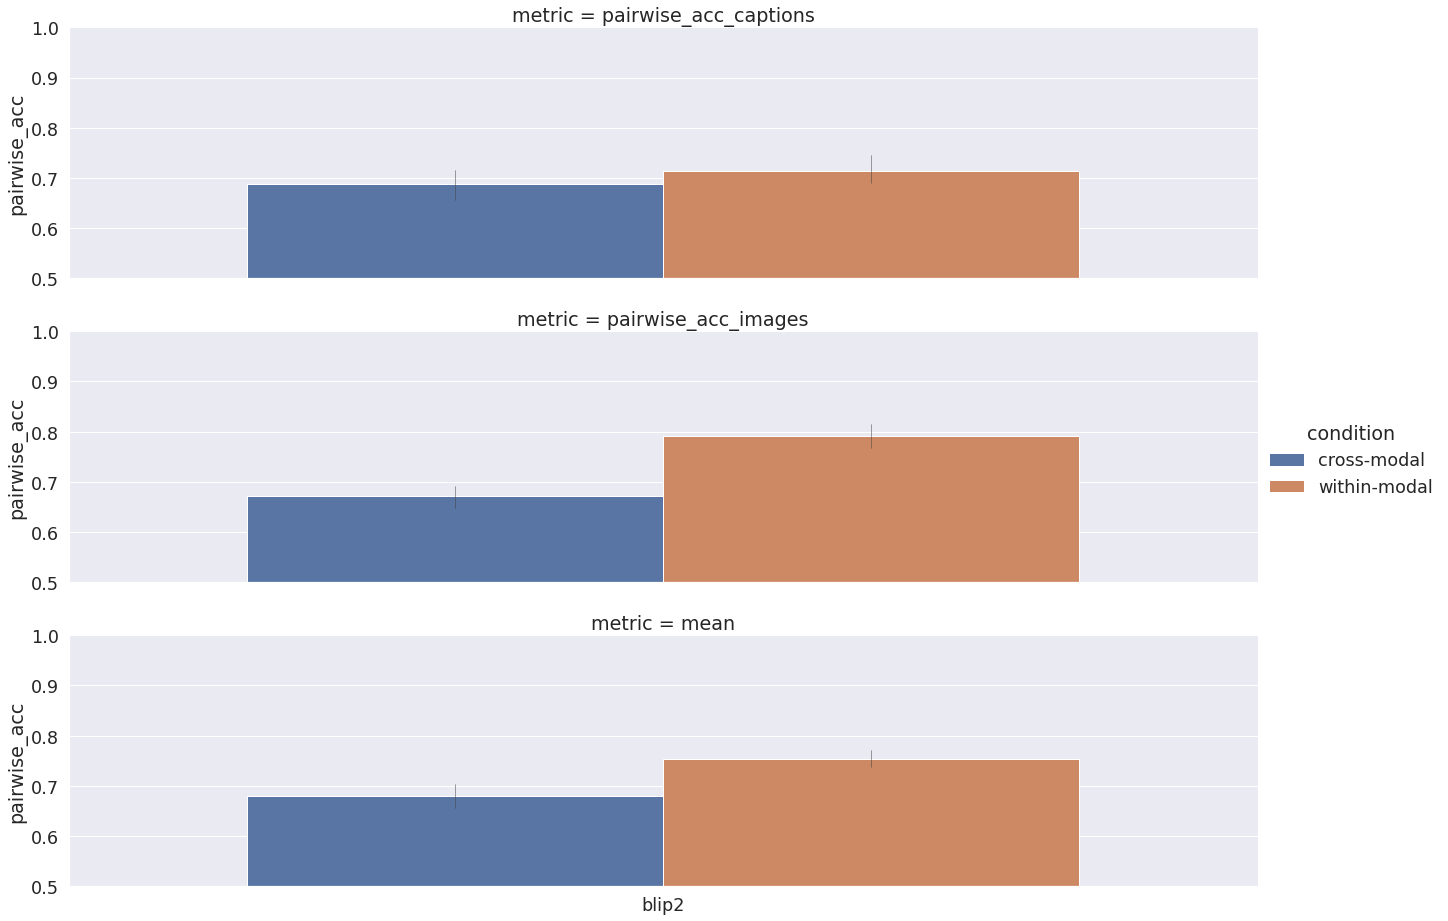

In [10]:
data_plotted = create_zero_shot_cross_modal_plot(data_matched_feats, model_order)
plt.savefig(os.path.join(RESULTS_DIR, f"zero_shot_cross_modal_glow.png"), bbox_inches='tight', pad_inches=0, dpi=300)

print(data_plotted[(data_plotted.metric == "mean")].groupby(["model", "condition"])['value'].mean())
print(data_plotted[(data_plotted.metric == "mean")].groupby(["model", "condition"])['value'].count())


# Zero-shot cross-modal decoding with GloW

In [13]:
models = ["glow", "glow-contrastive"]

data_models = load_results_data(models)
data_models

100%|██████████| 1196/1196 [00:02<00:00, 484.44it/s]


,alpha,model,subject,features,vision_features,lang_features,training_mode,mask,num_voxels,metric,value,surface,model_feat
0,100000.0,glow-contrastive,sub-01,concat,vision_features_mean,lang_features_cls,modality-agnostic,None,162649,pairwise_acc_modality_agnostic,0.860352,False,glow-contrastive_concat
1,100000.0,glow-contrastive,sub-01,concat,vision_features_mean,lang_features_cls,modality-agnostic,None,162649,pairwise_acc_captions,0.822774,False,glow-contrastive_concat
2,100000.0,glow-contrastive,sub-01,concat,vision_features_mean,lang_features_cls,modality-agnostic,None,162649,pairwise_acc_images,0.936025,False,glow-contrastive_concat
3,100000.0,glow-contrastive,sub-01,concat,vision_features_mean,lang_features_cls,modality-agnostic,None,162649,pairwise_acc_mean,0.879400,False,glow-contrastive_concat
4,100000.0,glow-contrastive,sub-01,lang,vision_features_mean,lang_features_cls,modality-agnostic,None,162649,pairwise_acc_modality_agnostic,0.859006,False,glow-contrastive_lang
...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,100000.0,glow,sub-07,matched,vision_features_mean,lang_features_cls,images,None,214739,pairwise_acc_mean,0.863354,False,glow_matched
572,100000.0,glow,sub-07,vision,vision_features_mean,lang_features_cls,images,None,214739,pairwise_acc_modality_agnostic,0.811801,False,glow_vision
573,100000.0,glow,sub-07,vision,vision_features_mean,lang_features_cls,images,None,214739,pairwise_acc_captions,0.746584,False,glow_vision
574,100000.0,glow,sub-07,vision,vision_features_mean,lang_features_cls,images,None,214739,pairwise_acc_images,0.955694,False,glow_vision


In [14]:
data_cls_feats = data_models.copy()
# for model in all_data.model.unique():
#     data_cls_feats = data_cls_feats[((data_cls_feats.model == model) & (data_cls_feats.vision_features == "vision_features_cls") & (data_cls_feats.lang_features == "lang_features_cls")) | (data_cls_feats.model != model)]

data_matched_feats = data_cls_feats[data_cls_feats.features == "matched"]


In [15]:
data_matched_feats = add_mean_cross_modal_and_within_modal_rows(data_matched_feats)

model
glow                0.739441
glow-contrastive    0.737629
Name: value, dtype: float64


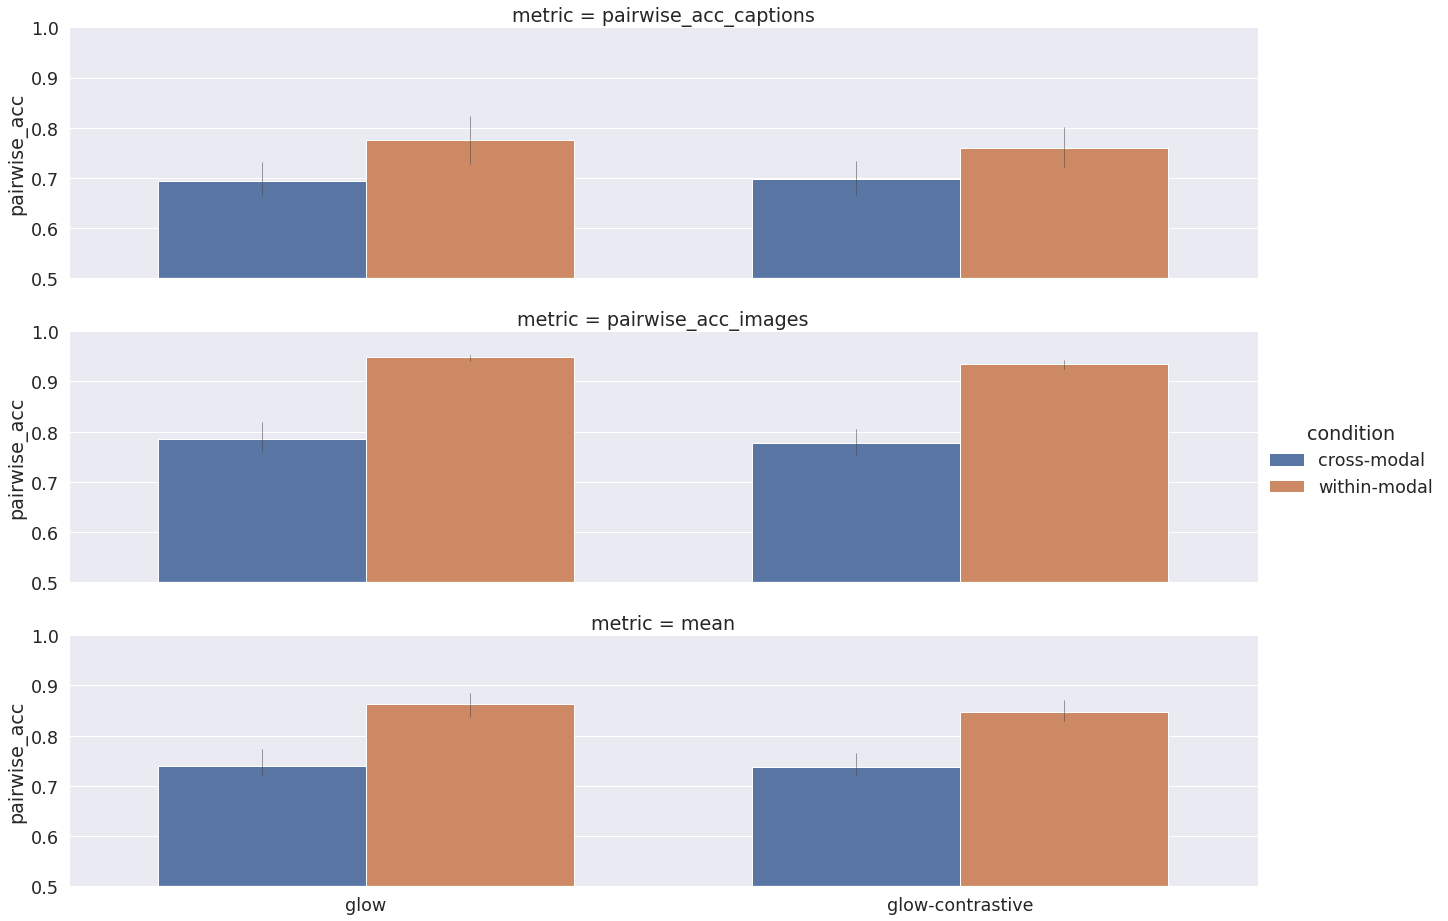

In [17]:
data_plotted = create_zero_shot_cross_modal_plot(data_matched_feats, models)
plt.savefig(os.path.join(RESULTS_DIR, f"zero_shot_cross_modal_glow.png"), bbox_inches='tight', pad_inches=0, dpi=300)

print(data_plotted[(data_plotted.training_mode == "cross-modal") & (data_plotted.metric == "mean")].groupby("model")['value'].mean())
